In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pwd

/cygdrive/c/Users/mlion/Documents/GitHub/GBCancerImage


In [3]:
%%bash
conda info -e

# conda environments:
#
base                     C:\ProgramData\Anaconda3
deep                  *  C:\Users\mlion\AppData\Local\conda\conda\envs\deep



#### Run the main.py from bash or shell

In [10]:
%%bash
python main.py --phase train

data folder already exists
Epoch 1/20
17/17 [==============================] - 4s 225ms/step - loss: 0.5204 - acc: 0.6930
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 0.3266 - acc: 0.8658
Epoch 3/20
17/17 [==============================] - 1s 32ms/step - loss: 0.2488 - acc: 0.8897
Epoch 4/20
17/17 [==============================] - 1s 32ms/step - loss: 0.2419 - acc: 0.9173
Epoch 5/20
15/17 [=========================>....] - ETA: 0s - loss: 0.1927 - acc: 0.9313
Epoch 00005: saving model to ./checkpoint\cp-0005.ckpt
17/17 [==============================] - 1s 55ms/step - loss: 0.1858 - acc: 0.9320
Epoch 6/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1821 - acc: 0.9265
Epoch 7/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1550 - acc: 0.9357
Epoch 8/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1521 - acc: 0.9393
Epoch 9/20
17/17 [==============================] - 1s 32ms/step - loss: 0.1254 - acc: 

2018-12-24 00:59:16.122784: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2018-12-24 00:59:16.322091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce RTX 2080 major: 7 minor: 5 memoryClockRate(GHz): 1.71
pciBusID: 0000:01:00.0
totalMemory: 8.00GiB freeMemory: 6.53GiB
2018-12-24 00:59:16.322443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2018-12-24 00:59:17.108319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-12-24 00:59:17.108501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2018-12-24 00:59:17.108617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2018-12-24 00:59:17.108839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/r

#### Import everything and run through python main()

data folder already exists
Epoch 1/20
17/17 [==============================] - 4s 226ms/step - loss: 0.6129 - acc: 0.7077
Epoch 2/20
17/17 [==============================] - 1s 33ms/step - loss: 0.3241 - acc: 0.8750
Epoch 3/20
17/17 [==============================] - 1s 33ms/step - loss: 0.2838 - acc: 0.8824
Epoch 4/20
17/17 [==============================] - 1s 33ms/step - loss: 0.1933 - acc: 0.9246: 0s - loss: 0.1997 - acc: 0.92
Epoch 5/20
15/17 [=========================>....] - ETA: 0s - loss: 0.2004 - acc: 0.9313
Epoch 00005: saving model to ./checkpoint\cp-0005.ckpt
17/17 [==============================] - 1s 57ms/step - loss: 0.1941 - acc: 0.9357
Epoch 6/20
17/17 [==============================] - 1s 33ms/step - loss: 0.1961 - acc: 0.9283
Epoch 7/20
17/17 [==============================] - 1s 33ms/step - loss: 0.1515 - acc: 0.9412
Epoch 8/20
17/17 [==============================] - 1s 33ms/step - loss: 0.1459 - acc: 0.9485: 0s - loss: 0.1397 - acc: 0.954 - ETA: 0s - loss: 0.1293

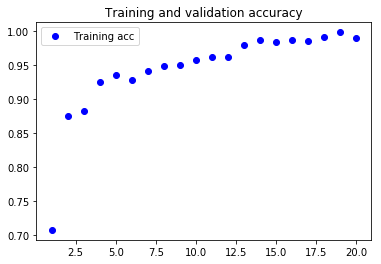

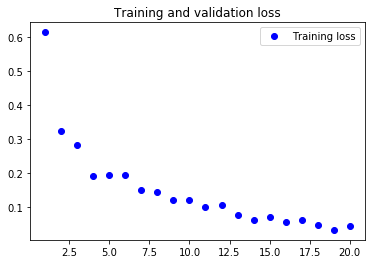

In [12]:
from main import *
if __name__ == "__main__":
    main()

In [5]:
from main import *

reload the latest model from checkpoint
predict done
Precision: 0.7391264563111515
Recall: 0.4678093730445379
F1: 0.5472097943331615
AUC score: 0.7135673237414428


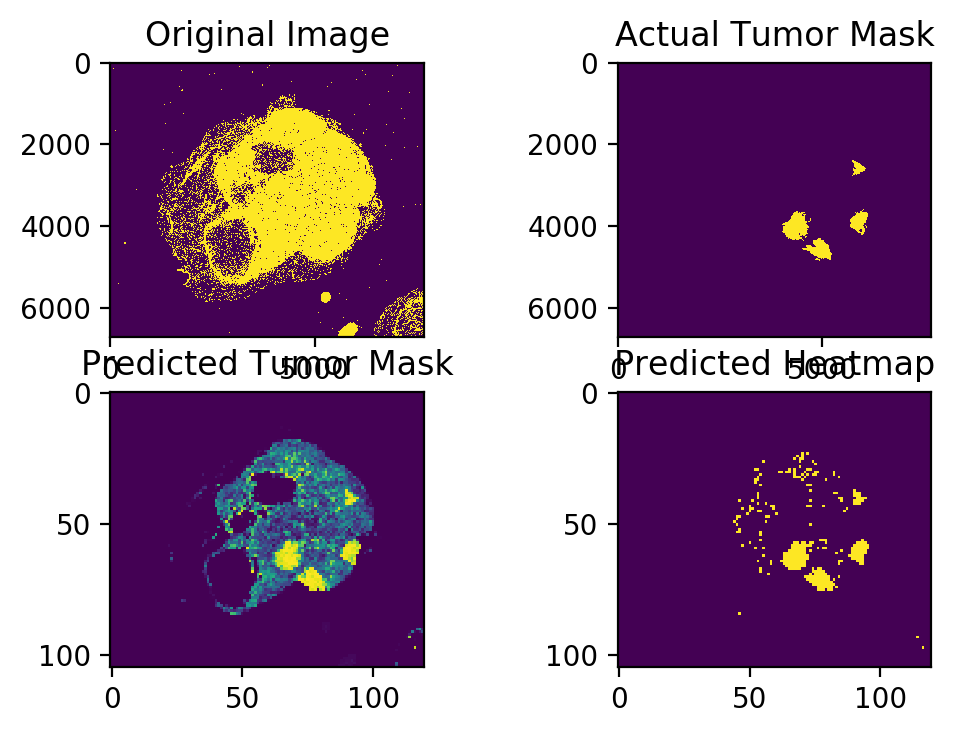

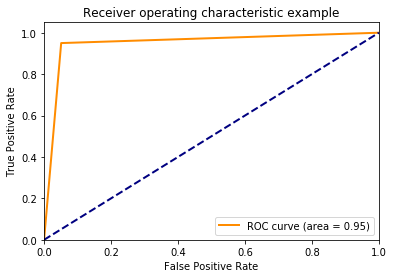

Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     11970989       644686
Reality 1        36450       692278
           Predicted 0  Predicted 1
Reality 0    89.707940     4.831134
Reality 1     0.273148     5.187778


In [6]:
if __name__ == "__main__":
    main()